# Glider Data

Explore glider dive data 

In [1]:
from scipy.io import loadmat
import numpy as np
import xarray as xr

import glidertools as gt
import matplotlib.pylab as plt
from matplotlib.colors import BoundaryNorm

from cmocean import cm as cmo

import gsw

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 12

In [3]:
data_dir = '/Users/dhruvbalwada/OneDrive/sogos_data'
data_659 = data_dir+'/data/interim/gliders/sg659/CTD_659.nc'
data_660 = data_dir+'/data/interim/gliders/sg660/CTD_660.nc'

In [31]:
ds_659 = xr.load_dataset(data_659)
ds_660 = xr.load_dataset(data_660)

In [5]:
print(ds_659.time[0].values)
print(ds_659.time[-1].values)

2019-04-30T13:20:51.230003456
2019-07-26T01:58:44.700995328


In [9]:
#xr.merge([ds_659.longitude, ds_659.latitude]).to_netcdf('659_locs.nc')

In [10]:
#xr.merge([ds_660.longitude, ds_660.latitude]).to_netcdf('660_locs.nc')

In [9]:
lon_659 = ds_659.longitude.groupby(ds_659.dives).mean()
lat_659 = ds_659.latitude.groupby(ds_659.dives).mean()

lon_660 = ds_660.longitude.groupby(ds_660.dives).mean()
lat_660 = ds_660.latitude.groupby(ds_660.dives).mean()

#### Some rough data sections
to get a feel for the fata

In [8]:
def great_circle_distance(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance between one or multiple pairs of
    points given in spherical coordinates. Spherical coordinates are expected
    in degrees. Angle definition follows standard longitude/latitude definition.
    This uses the arctan version of the great-circle distance function
    (en.wikipedia.org/wiki/Great-circle_distance) for increased
    numerical stability.
    Parameters
    ----------
    lon1: float scalar or numpy array
        Longitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lat1: float scalar or numpy array
        Latitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lon2: float scalar or numpy array
        Longitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    lat2: float scalar or numpy array
        Latitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    Calculation of distances follows numpy elementwise semantics, so if
    an array of length N is passed, all input parameters need to be
    arrays of length N or scalars.
    Returns
    -------
    distance: float scalar or numpy array
        The great circle distance(s) (in degrees) between the
        given pair(s) of points.
    """
    # Convert to radians:
    lat1 = np.array(lat1) * np.pi / 180.0
    lat2 = np.array(lat2) * np.pi / 180.0
    dlon = (lon1 - lon2) * np.pi / 180.0

    # Evaluate trigonometric functions that need to be evaluated more
    # than once:
    c1 = np.cos(lat1)
    s1 = np.sin(lat1)
    c2 = np.cos(lat2)
    s2 = np.sin(lat2)
    cd = np.cos(dlon)

    # This uses the arctan version of the great-circle distance function
    # from en.wikipedia.org/wiki/Great-circle_distance for increased
    # numerical stability.
    # Formula can be obtained from [2] combining eqns. (14)-(16)
    # for spherical geometry (f=0).

    return (
        180.0
        / np.pi
        * np.arctan2(
            np.sqrt((c2 * np.sin(dlon)) ** 2 + (c1 * s2 - s1 * c2 * cd) ** 2),
            s1 * s2 + c1 * c2 * cd,
        )
    )

In [10]:
# convert lat-lon to local tangent plane 

origin_lat = -53.5 #S
origin_lon = 29.5  #E

X_659 = great_circle_distance(origin_lon, lat_659, 
                          lon_659, lat_659)*110
Y_659 = great_circle_distance(lon_659, origin_lat, 
                          lon_659, lat_659)*110


X_660 = great_circle_distance(origin_lon, lat_660, 
                          lon_660, lat_660)*110
Y_660 = great_circle_distance(lon_660, origin_lat, 
                          lon_660, lat_660)*110



In [11]:
days = ds_659.time - np.datetime64('2019-01-01')
days_round_659 = (days / np.timedelta64(1, 'D')).round()

days = ds_660.time - np.datetime64('2019-01-01')
days_round_660 = (days / np.timedelta64(1, 'D')).round()

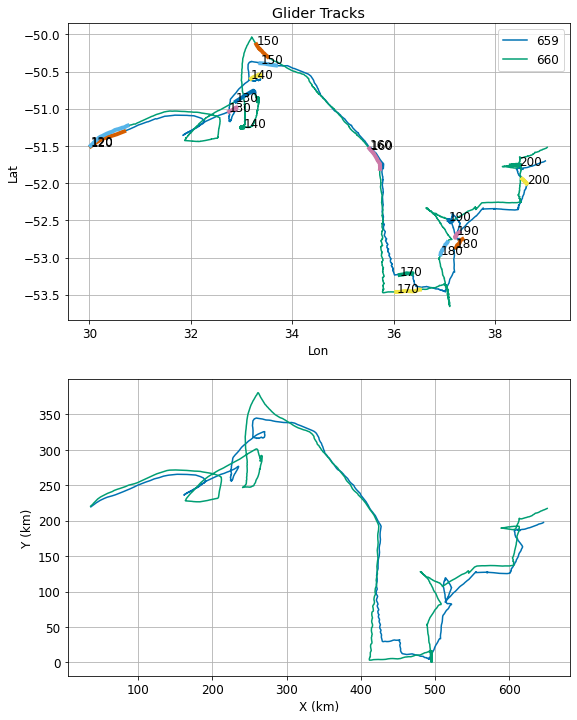

In [18]:
plt.figure(figsize = (9,12))

plt.subplot(211)
plt.plot(ds_659.longitude, ds_659.latitude, label='659')
plt.plot(ds_660.longitude, ds_660.latitude, label='660')
plt.legend()
days = np.linspace(120,200,9)
for i in days: 
    plt.plot(ds_659.longitude.where(days_round_659==i, drop=True), 
             ds_659.latitude.where(days_round_659==i, drop=True), linewidth=4)
    plt.text(ds_659.longitude.where(days_round_659==i, drop=True)[0], 
             ds_659.latitude.where(days_round_659==i, drop=True)[0], int(i))
    

#plt.subplot(122)


plt.legend()
days = np.linspace(120,200,9)
for i in days: 
    plt.plot(ds_660.longitude.where(days_round_660==i, drop=True), 
             ds_660.latitude.where(days_round_660==i, drop=True), linewidth=4)
    plt.text(ds_660.longitude.where(days_round_660==i, drop=True)[0], 
             ds_660.latitude.where(days_round_660==i, drop=True)[0], int(i))    
    
plt.grid()
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.title('Glider Tracks')

plt.subplot(212)
plt.plot(X_659, Y_659, label='659')
plt.plot(X_660, Y_660, label='660')
plt.grid()
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.savefig('glider_tracks.pdf')

In [39]:
dist_659 = gt.utils.distance(ds_659.longitude, 
                       ds_659.latitude)

ds_659['distance'] = xr.DataArray(np.cumsum(dist_659), 
                           dims= ['ctd_data_point'])

In [42]:
dist_660 = gt.utils.distance(ds_660.longitude, 
                       ds_660.latitude)
ds_660['distance'] = xr.DataArray(np.cumsum(dist_660), 
                           dims= ['ctd_data_point'])

# Fields 

ValueError: Could not convert object to NumPy datetime

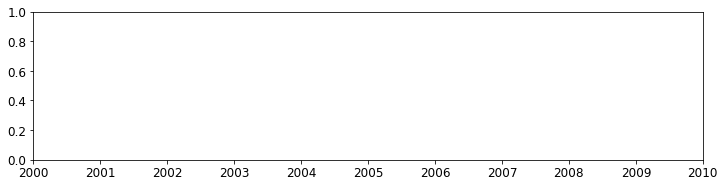

In [215]:
ndives = 50

plt.figure(figsize=(12, 6))

plt.subplot(211)
plt.scatter(ds_659.time.where(ds_659.dives<ndives, drop=True), 
            ds_659.pressure.where(ds_659.dives<ndives, drop=True), 
            c = ds_659.temperature.where(ds_659.dives<ndives, drop=True), 
            s=1, cmap=cmo.thermal)

plt.gca().invert_yaxis()
#plt.colorbar()

plt.xlabel('Time')
plt.ylabel('Depth (m)')


plt.subplot(212)
plt.scatter(ds_659.distance.where(ds_659.dives<ndives, drop=True)/1e3, 
            ds_659.pressure.where(ds_659.dives<ndives, drop=True), 
            c = ds_659.temperature.where(ds_659.dives<ndives, drop=True), 
            s=1, cmap=cmo.thermal)

plt.gca().invert_yaxis()

plt.xlabel('Distance (km)')
plt.ylabel('Depth (m)')

plt.tight_layout()

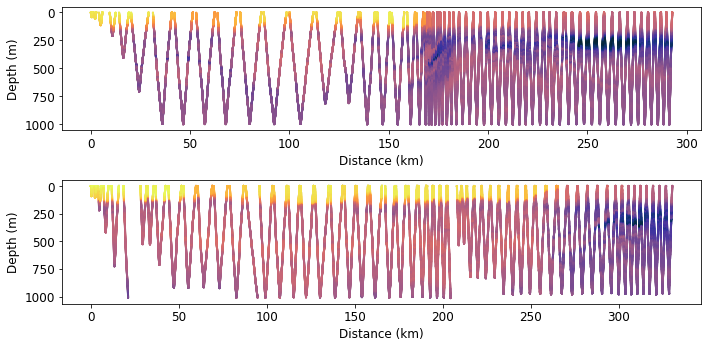

In [44]:
ndives = 60

plt.figure(figsize=(10, 5))

plt.subplot(211)
plt.scatter(ds_659.distance.where(ds_659.dives<ndives, drop=True)/1e3, 
            ds_659.pressure.where(ds_659.dives<ndives, drop=True), 
            c = ds_659.temperature.where(ds_659.dives<ndives, drop=True), 
            s=1, cmap=cmo.thermal)

plt.gca().invert_yaxis()

plt.xlabel('Distance (km)')
plt.ylabel('Depth (m)')


plt.subplot(212)
plt.scatter(ds_660.distance.where(ds_660.dives<ndives, drop=True)/1e3, 
            ds_660.pressure.where(ds_660.dives<ndives, drop=True), 
            c = ds_660.temperature.where(ds_660.dives<ndives, drop=True), 
            s=1, cmap=cmo.thermal)

plt.gca().invert_yaxis()

plt.xlabel('Distance (km)')
plt.ylabel('Depth (m)')
plt.tight_layout()

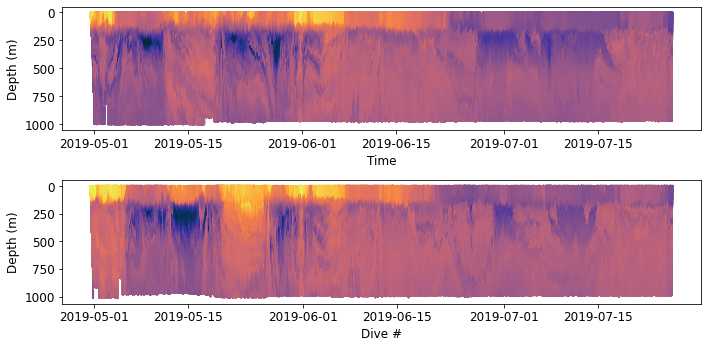

In [23]:
ndives = 600

plt.figure(figsize=(10, 5))

plt.subplot(211)
plt.scatter(ds_659.time.where(ds_659.dives<ndives, drop=True), 
            ds_659.pressure.where(ds_659.dives<ndives, drop=True), 
            c = ds_659.temperature.where(ds_659.dives<ndives, drop=True), 
            s=1, cmap=cmo.thermal)

plt.gca().invert_yaxis()

plt.xlabel('Time')
plt.ylabel('Depth (m)')


plt.subplot(212)
plt.scatter(ds_660.time.where(ds_660.dives<ndives, drop=True), 
            ds_660.pressure.where(ds_660.dives<ndives, drop=True), 
            c = ds_660.temperature.where(ds_660.dives<ndives, drop=True), 
            s=1, cmap=cmo.thermal)

plt.gca().invert_yaxis()

plt.xlabel('Dive #')
plt.ylabel('Depth (m)')
plt.tight_layout()

In [19]:
gt.plot(ds_659.time, ds_659.pressure, ds_659.temperature, cmap=cmo.thermal, robust=True)
plt.title('Temp Data 659')

gt.plot(ds_660.time, ds_660.pressure, ds_660.temperature, cmap=cmo.thermal, robust=True)
plt.title('Temp Data 660')

UserWarning: The x input array must be psuedo discrete (dives or dive_time). 100% of x is unique (max 20% unique)

In [50]:
dens_659 = gsw.sigma0(ds_659.salinity, ds_659.temperature)
dens_660 = gsw.sigma0(ds_660.salinity, ds_660.temperature)
ds_659['density'] = xr.DataArray(
            data=dens_659,
            coords=ds_659.coords,
            dims=ds_659.dims,
            name='density'
        )

ds_660['density'] = xr.DataArray(
            data=dens_660,
            coords=ds_660.coords,
            dims=ds_660.dims,
            name='density'
        )

Text(0.5, 1, 'Density Data 660')

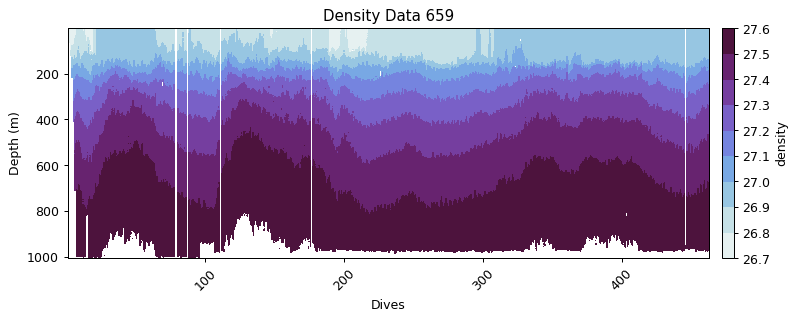

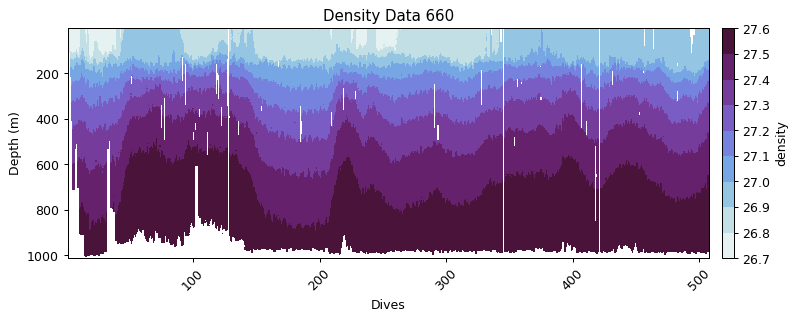

In [10]:
gt.plot.contourf(ds_659.dives, ds_659.pressure, ds_659.density,
                 cmap=cmo.dense, levels=np.linspace(26.7, 27.6,10),robust=True)
plt.title('Density Data 659')

gt.plot.contourf(ds_660.dives, ds_660.pressure, ds_660.density,
                 cmap=cmo.dense, levels=np.linspace(26.7, 27.6,10), robust=True)
plt.title('Density Data 660')

In [13]:
def dive_coords (ds): 
    # Find avg lon/latitude/time over a certain dive numbers
    # added for ease of plotting
    
    temp = np.zeros_like(ds.latitude)

    temp = xr.DataArray(
                data=temp,
                coords=ds.coords,
                dims=ds.dims,
                name='density'
            )

    latitude_dive = temp.groupby(ds.dives) + ds.latitude.groupby(ds.dives).mean()
    latitude_dive=latitude_dive.rename('latitude_dive')
    longitude_dive = temp.groupby(ds.dives) + ds.longitude.groupby(ds.dives).mean()
    longitude_dive = longitude_dive.rename('longitude_dive')
    
    time_dive = temp.groupby(ds.dives) + ds.time.astype('float').groupby(ds.dives).mean()
    time_dive = time_dive.rename('time_dive')

    return xr.merge([ds.assign_coords(dives=ds.dives), 
              latitude_dive, longitude_dive, time_dive ])

In [15]:
ds_659 = dive_coords(ds_659)
ds_660 = dive_coords(ds_660)

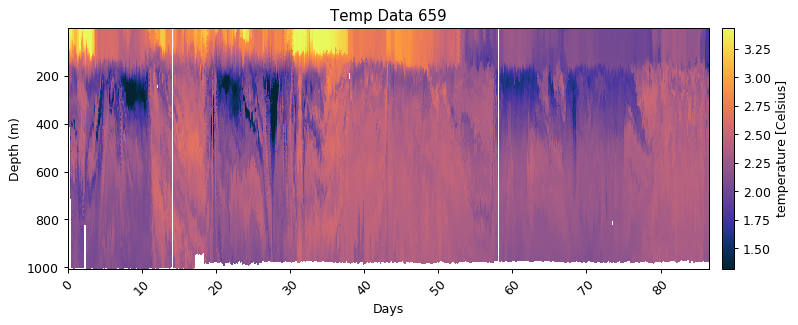

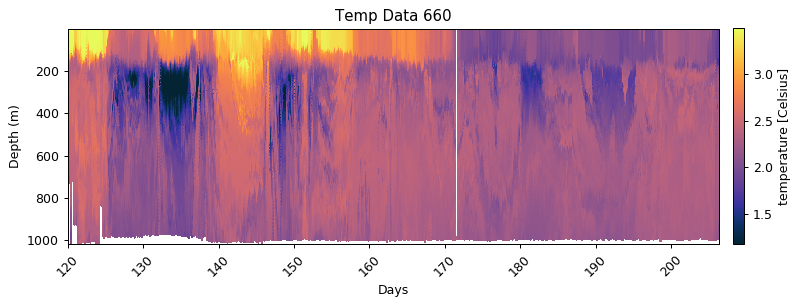

In [271]:
gt.plot((ds_659.time_dive-ds_659.time_dive[0])/1e9/3600/24, ds_659.pressure, 
        ds_659.temperature,
                 cmap=cmo.thermal, robust=True)
plt.title('Temp Data 659')
plt.xlabel('Days')

gt.plot((ds_660.time_dive-ds_660.time_dive[0])/1e9/3600/24 + 120, ds_660.pressure, 
        ds_660.temperature,
                 cmap=cmo.thermal, robust=True)
plt.title('Temp Data 660')
plt.xlabel('Days')

plt.tight_layout()
plt.savefig('temp_vs_days_660.pdf')

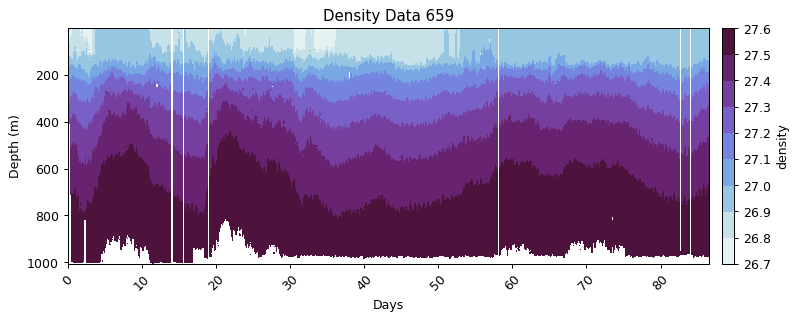

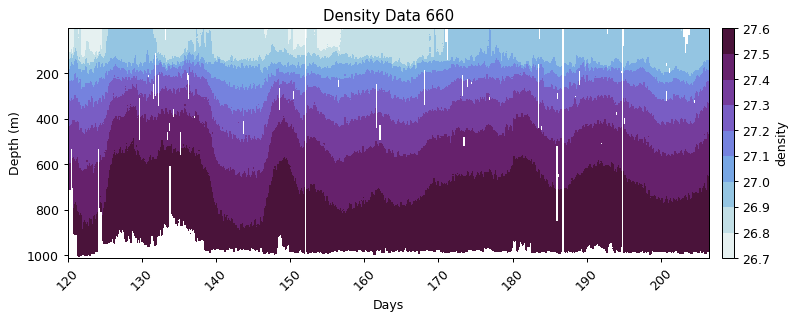

In [270]:
gt.plot.contourf((ds_659.time_dive-ds_659.time_dive[0])/1e9/3600/24, ds_659.pressure, ds_659.density,
                 cmap=cmo.dense, levels=np.linspace(26.7, 27.6,10),robust=True)
plt.title('Density Data 659')
plt.xlabel('Days')

gt.plot.contourf((ds_660.time_dive-ds_660.time_dive[0])/1e9/3600/24 + 120, ds_660.pressure, ds_660.density,
                 cmap=cmo.dense, levels=np.linspace(26.7, 27.6,10), robust=True)
plt.title('Density Data 660')
plt.xlabel('Days')
plt.savefig('density_vs_days_660.pdf')

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/glidertools/plot.py:224: UserWarning: The following kwargs were not used by contour: 'rasterized'
  im = ax.contourf(x, y, z, **kwargs)


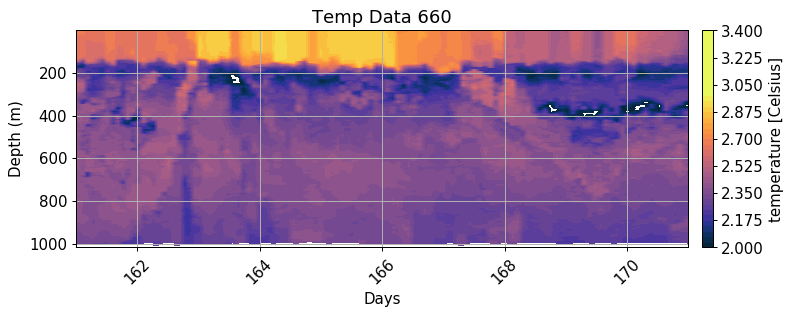

In [302]:
gt.plot.contourf((ds_660.time_dive -ds_660.time_dive[0])/1e9/3600/24 + 120, 
         ds_660.pressure, 
        ds_660.temperature,
                 cmap=cmo.thermal, vmin=2, vmax=3., levels=np.linspace(2.,3.4,41), 
                 rasterized=True, robust=True)
plt.title('Temp Data 660')
plt.xlabel('Days')
plt.xlim([161, 171])
plt.grid()
#plt.tight_layout()
plt.savefig('temp_vs_days_660_eddy.png')

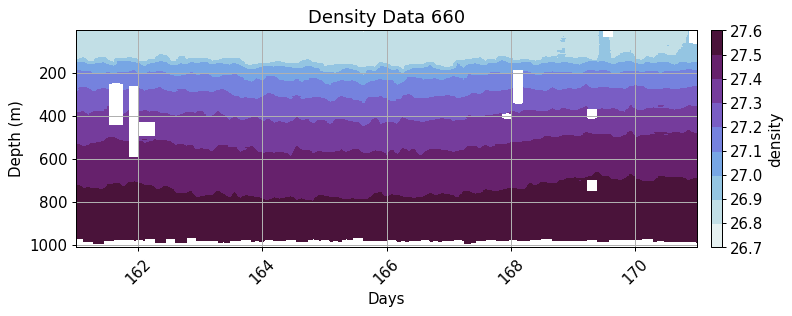

In [300]:
#plt.figure(figsize=(8,5))
gt.plot.contourf((ds_660.time_dive-ds_660.time_dive[0])/1e9/3600/24 + 120, ds_660.pressure, ds_660.density,
                 cmap=cmo.dense, levels=np.linspace(26.7, 27.6,10), robust=True)
plt.title('Density Data 660')
plt.xlabel('Days')
plt.xlim([161, 171])
plt.grid()
plt.savefig('density_vs_days_660_eddy.pdf')

In [52]:
ds_659['potdens'] = gt.physics.potential_density(ds_659.salinity, 
                                                 ds_659.temperature, 
                                                 ds_659.pressure, 
                                                 ds_659.latitude, 
                                                 ds_659.longitude)

ds_660['potdens'] = gt.physics.potential_density(ds_660.salinity, 
                                                 ds_660.temperature, 
                                                 ds_660.pressure,
                                                 ds_660.latitude, 
                                                 ds_660.longitude)


In [53]:
ds_659['spice'] = gt.physics.spice0(ds_659.salinity, 
                         ds_659.temperature, 
                         ds_659.pressure, 
                         ds_659.latitude, 
                         ds_659.longitude)

ds_660['spice'] = gt.physics.spice0(ds_660.salinity, 
                         ds_660.temperature, 
                         ds_660.pressure, 
                         ds_660.latitude, 
                         ds_660.longitude)

In [55]:
# easier to work with a days variable that is a float rather than datenum
days = ds_659.time - np.datetime64('2019-01-01')
ds_659['days'] = (days / np.timedelta64(1, 'D'))

days = ds_660.time - np.datetime64('2019-01-01')
ds_660['days'] = (days / np.timedelta64(1, 'D'))

In [56]:
# Interpolate and grid glider data on pressure-time axis
# There are many ways this can be done. We choose a simple linear interpolation in time and pressure
# We could alternatively interpolate in density-time, pressure-distance, dive-pressure etc.
# This a place where a lot of more work into GP and 
# learning the most optimal interpolation (in sense of MLE) might work. 

# Note this is different from what glidertools does, which does a simple binning. 

from scipy.interpolate import griddata
# interpolate on pressure-time 
def interp_pres_time(ds_glid, var): 
    pres_ug = ds_glid.pressure
    time_ug = ds_glid.days
    
    # convert to points values
    points = np.stack([time_ug.values, pres_ug.values],
                       axis=1)
    values = ds_glid[var].values
    
    # remove nans
    non_nan = np.logical_and(np.logical_and(~np.isnan(points[:,0]), 
                                      ~np.isnan(points[:,1])),
                                      ~np.isnan(values))
    
    points =points[non_nan,:]
    values =values[non_nan]
    
    # define grid
    pres_grid = np.linspace(0,1000,1001)
    time_grid = np.arange(119, 207, 0.025)
    grid_p, grid_t = np.meshgrid(pres_grid, time_grid)
    
    temp_grided = griddata(points, values, 
                         (grid_t, grid_p), 
                         method='linear', rescale=True)
    
    return xr.DataArray(temp_grided.T, 
                               dims=["pressure", "time"],
                          coords={"pressure":pres_grid,
                                    "time":time_grid}).rename(var)

# apply to all useful glider variables 
# can later add in variables measured by other instruments too 
def convert_glider(ds_glid, vars_convert= ['temperature','salinity','potdens','spice']):
    
    #vars_convert = ['temperature','salinity','potdens']
    
    ds_grid = xr.Dataset()
    
    for v in vars_convert:
            ds_grid[v] = interp_pres_time(ds_glid, v)
    
    return ds_grid

In [57]:
# convert from point data to gridded data, can take some time
ds_659_grid = convert_glider(ds_659)
ds_660_grid = convert_glider(ds_660)

In [213]:
24*60*0.025

36.0

In [58]:
def interp_dens_time(ds_glid, var): 
    dens_ug = ds_glid.potdens
    time_ug = ds_glid.days
    
    # convert to points values
    points = np.stack([time_ug.values, dens_ug.values],
                       axis=1)
    values = ds_glid[var].values
    
    # remove nans
    non_nan = np.logical_and(np.logical_and(~np.isnan(points[:,0]), 
                                      ~np.isnan(points[:,1])),
                                      ~np.isnan(values))
    
    points =points[non_nan,:]
    values =values[non_nan]
    
    # define grid
    dens_grid = np.linspace(1026.8,1027.8,1001)
    time_grid = np.arange(119, 207, 0.025)
    grid_d, grid_t = np.meshgrid(dens_grid, time_grid)
    
    temp_grided = griddata(points, values, 
                         (grid_t, grid_d), 
                         method='linear', rescale=True)
    
    return xr.DataArray(temp_grided.T, 
                               dims=["potdens", "time"],
                          coords={"potdens":dens_grid,
                                    "time":time_grid}).rename(var)

def convert_glider_dens(ds_glid, vars_convert= ['temperature','salinity','pressure','spice','latitude','longitude']):
       
    ds_grid = xr.Dataset()
    
    for v in vars_convert:
            ds_grid[v] = interp_dens_time(ds_glid, v)
    
    return ds_grid

In [59]:
ds_659_iso = convert_glider_dens(ds_659)
ds_660_iso = convert_glider_dens(ds_660)

In [71]:
ds_659_grid

<xarray.Dataset>
Dimensions:      (pressure: 1001, time: 3520)
Coordinates:
  * pressure     (pressure) float64 0.0 1.0 2.0 3.0 ... 997.0 998.0 999.0 1e+03
  * time         (time) float64 119.0 119.0 119.1 119.1 ... 206.9 207.0 207.0
Data variables:
    temperature  (pressure, time) float64 nan nan nan nan ... nan nan nan nan
    salinity     (pressure, time) float64 nan nan nan nan ... nan nan nan nan
    potdens      (pressure, time) float64 nan nan nan nan ... nan nan nan nan
    spice        (pressure, time) float64 nan nan nan nan ... nan nan nan nan

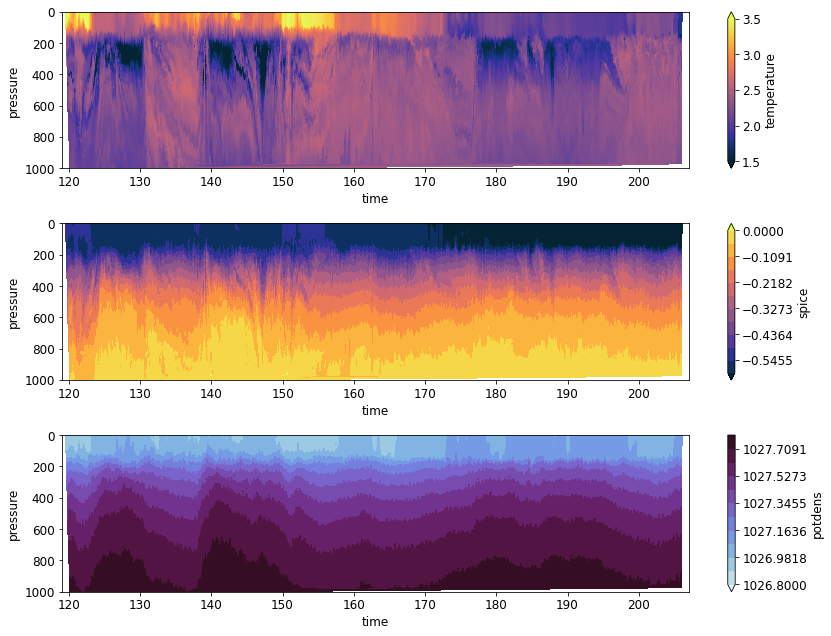

In [70]:
plt.figure(figsize=(12,9))

plt.subplot(311)
ds_659_grid.temperature.plot(vmin=1.5, vmax=3.5, cmap=cmo.thermal)
plt.gca().invert_yaxis()

plt.subplot(312)
ds_659_grid.spice.plot(vmin=-0.6, vmax=0, levels=12, cmap=cmo.thermal)
plt.gca().invert_yaxis()

plt.subplot(313)
ds_659_grid.potdens.plot.contourf(vmin= 1026.8,vmax= 1027.8, levels=12, cmap=cmo.dense)
plt.gca().invert_yaxis()

plt.tight_layout()

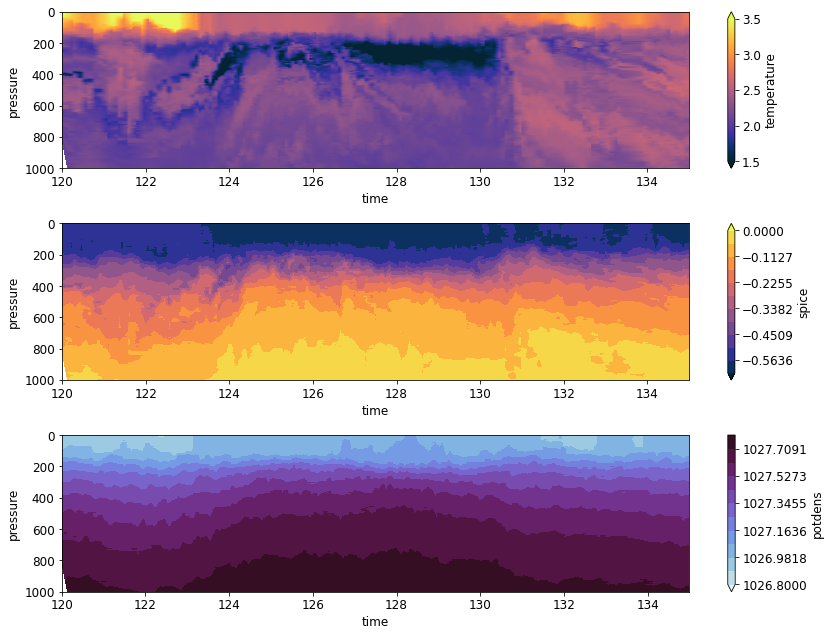

In [75]:
plt.figure(figsize=(12,9))

plt.subplot(311)
ds_659_grid.temperature.sel(time=slice(120,135)).plot(vmin=1.5, vmax=3.5, cmap=cmo.thermal)
plt.gca().invert_yaxis()


plt.subplot(312)
ds_659_grid.spice.sel(time=slice(120,135)).plot(vmin=-0.62, vmax=0, levels=12, cmap=cmo.thermal)
plt.gca().invert_yaxis()

plt.subplot(313)
ds_659_grid.potdens.sel(time=slice(120,135)).plot.contourf(vmin= 1026.8,vmax= 1027.8, levels=12, cmap=cmo.dense)
plt.gca().invert_yaxis()

plt.tight_layout()

### Spectra

In [86]:
import xrft

In [88]:
ds_659_grid.temperature

<xarray.DataArray 'temperature' (pressure: 1001, time: 3520)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * pressure  (pressure) float64 0.0 1.0 2.0 3.0 4.0 ... 997.0 998.0 999.0 1e+03
  * time      (time) float64 119.0 119.0 119.1 119.1 ... 206.9 206.9 207.0 207.0

In [89]:
ds_659_grid.temperature.sel(pressure=slice(200, 700)).dropna(dim='time')

<xarray.DataArray 'temperature' (pressure: 501, time: 3444)>
array([[2.25913805, 2.27172484, 2.27317103, ..., 2.19030728, 2.18327606,
        2.17624485],
       [2.26581268, 2.2786742 , 2.27955428, ..., 2.20189931, 2.196338  ,
        2.19078547],
       [2.26622917, 2.28038111, 2.28349392, ..., 2.20949139, 2.20679816,
        2.20410494],
       ...,
       [2.08495482, 2.08762279, 2.09029077, ..., 2.33414579, 2.3394176 ,
        2.34468131],
       [2.09193082, 2.09344639, 2.09496195, ..., 2.33566657, 2.34023246,
        2.34488069],
       [2.09579391, 2.09691554, 2.09803718, ..., 2.33492062, 2.33996042,
        2.34499733]])
Coordinates:
  * pressure  (pressure) float64 200.0 201.0 202.0 203.0 ... 698.0 699.0 700.0
  * time      (time) float64 119.9 120.0 120.0 120.0 ... 205.9 206.0 206.0 206.0

In [162]:
temp_spec_659 = xrft.power_spectrum(ds_659_grid.temperature.sel(pressure=slice(200, 700)).dropna(dim='time'),
                               dim='time', window=True)
dens_spec_659 = xrft.power_spectrum(ds_659_grid.potdens.sel(pressure=slice(200, 700)).dropna(dim='time'),
                               dim='time', window=True)

In [163]:
temp_spec_660 = xrft.power_spectrum(ds_660_grid.temperature.sel(pressure=slice(200, 700)).dropna(dim='time'),
                               dim='time', window=True)
dens_spec_660 = xrft.power_spectrum(ds_660_grid.potdens.sel(pressure=slice(200, 700)).dropna(dim='time'),
                               dim='time', window=True)

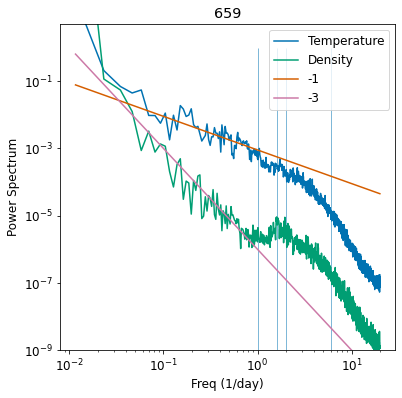

In [167]:
plt.figure(figsize=(6,6))
temp_spec_659.mean('pressure').plot(label='Temperature')
dens_spec_659.mean('pressure').plot(label='Density')


plt.plot(temp_spec.freq_time, 0.9e-3*temp_spec.freq_time**(-1), label='-1')
plt.plot(temp_spec.freq_time, 1e-6*temp_spec.freq_time**-3, label='-3')

plt.xscale('log')
plt.yscale('log')

plt.vlines([1/(4/24),1/(12/24), 1/(15/24), 1], 1e-9, 1, linewidths=0.5)

plt.ylim([1e-9, 5])

plt.xlabel('Freq (1/day)')
plt.ylabel('Power Spectrum')
plt.title('659')
plt.legend()

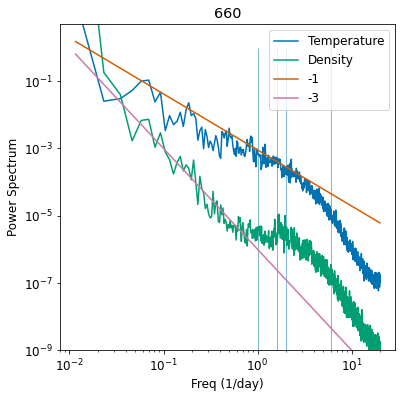

In [168]:
plt.figure(figsize=(6,6))
temp_spec_660.mean('pressure').plot(label='Temperature')
dens_spec_660.mean('pressure').plot(label='Density')


plt.plot(temp_spec.freq_time, 0.9e-3*temp_spec.freq_time**(-5/3), label='-1')
plt.plot(temp_spec.freq_time, 1e-6*temp_spec.freq_time**-3, label='-3')

plt.xscale('log')
plt.yscale('log')

plt.vlines([1/(4/24),1/(12/24), 1/(15/24), 1], 1e-9, 1, linewidths=0.5)

plt.ylim([1e-9, 5])

plt.xlabel('Freq (1/day)')
plt.ylabel('Power Spectrum')
plt.title('660')
plt.legend()

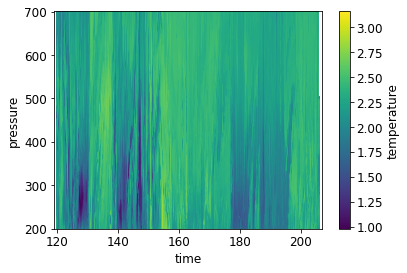

In [127]:
ds_659_grid.temperature.sel(pressure=slice(200, 700)).plot()

In [171]:
temp_anom = ds_659_grid.temperature - ds_659_grid.temperature.mean('time')
dens_anom = ds_659_grid.potdens - ds_659_grid.potdens.mean('time')

In [172]:
temp_spec_pres = xrft.power_spectrum(ds_659_grid.temperature.sel(pressure=slice(150, 950)).dropna(dim='time'),
                               dim='pressure', window=True)

dens_spec_pres = xrft.power_spectrum(ds_659_grid.potdens.sel(pressure=slice(150, 950)).dropna(dim='time'),
                               dim='pressure', window=True)

In [173]:
temp_anom_spec_pres = xrft.power_spectrum(temp_anom.sel(pressure=slice(150, 950)).dropna(dim='time'),
                               dim='pressure', window=True)

dens_anom_spec_pres = xrft.power_spectrum(dens_anom.sel(pressure=slice(150, 950)).dropna(dim='time'),
                               dim='pressure', window=True)

Text(0.5, 1.0, 'temp vertical spectrum')

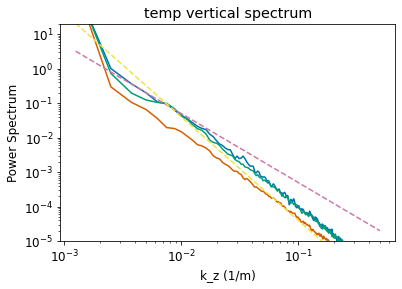

In [174]:
temp_spec_pres.sel(time=slice(120,130)).mean('time').plot(label='120-130')
temp_spec_pres.sel(time=slice(130,150)).mean('time').plot(label='130-150')
temp_spec_pres.sel(time=slice(150,200)).mean('time').plot(label='150-200')

kz = temp_spec_pres.freq_pressure
plt.plot(kz, 0.5e-5*kz**(-2), '--', label='-2')
plt.plot(kz, 4e-8*kz**(-3), '--', label='-3')

plt.ylim([1e-5 , 20])
plt.xscale('log')
plt.yscale('log')

plt.xlabel('k_z (1/m)')
plt.ylabel('Power Spectrum')
plt.title('temp vertical spectrum')

Text(0.5, 1.0, 'temp vertical spectrum')

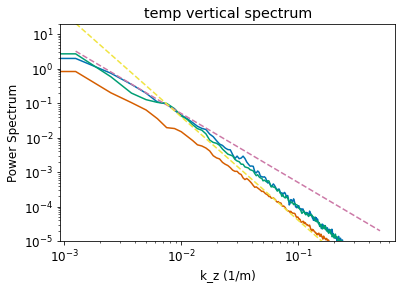

In [175]:
temp_anom_spec_pres.sel(time=slice(120,130)).mean('time').plot(label='120-130')
temp_anom_spec_pres.sel(time=slice(130,150)).mean('time').plot(label='130-150')
temp_anom_spec_pres.sel(time=slice(150,200)).mean('time').plot(label='150-200')

kz = temp_spec_pres.freq_pressure
plt.plot(kz, 0.5e-5*kz**(-2), '--', label='-2')
plt.plot(kz, 4e-8*kz**(-3), '--', label='-3')

plt.ylim([1e-5 , 20])
plt.xscale('log')
plt.yscale('log')

plt.xlabel('k_z (1/m)')
plt.ylabel('Power Spectrum')
plt.title('temp vertical spectrum')

Text(0.5, 1.0, 'Temp vertical spectrum')

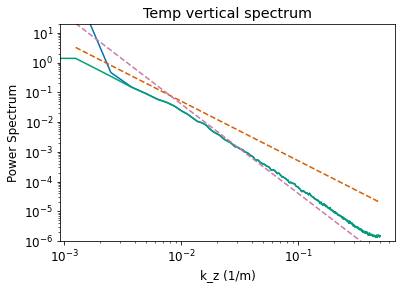

In [176]:
temp_spec_pres.mean('time').plot(label='Total')
temp_anom_spec_pres.mean('time').plot(label='Anomaly')

kz = temp_spec_pres.freq_pressure
plt.plot(kz, 0.5e-5*kz**(-2), '--', label='-2')
plt.plot(kz, 4e-8*kz**(-3), '--', label='-3')

plt.ylim([1e-6 , 20])
plt.xscale('log')
plt.yscale('log')

plt.xlabel('k_z (1/m)')
plt.ylabel('Power Spectrum')
plt.title('Temp vertical spectrum')

Text(0.5, 1.0, 'Density vertical spectrum')

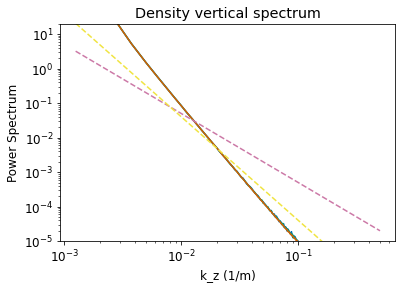

In [177]:
dens_spec_pres.sel(time=slice(120,130)).mean('time').plot(label='120-130')
dens_spec_pres.sel(time=slice(130,150)).mean('time').plot(label='130-150')
dens_spec_pres.sel(time=slice(150,200)).mean('time').plot(label='150-200')

kz = temp_spec_pres.freq_pressure
plt.plot(kz, 0.5e-5*kz**(-2), '--', label='-2')
plt.plot(kz, 4e-8*kz**(-3), '--', label='-3')

plt.ylim([1e-5 , 20])
plt.xscale('log')
plt.yscale('log')

plt.xlabel('k_z (1/m)')
plt.ylabel('Power Spectrum')
plt.title('Density vertical spectrum')

Text(0.5, 1.0, 'Density vertical spectrum')

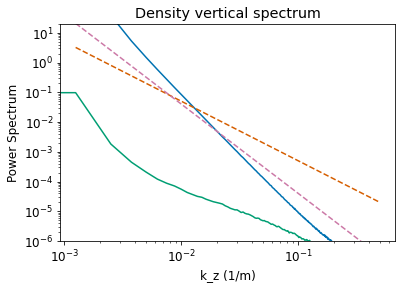

In [178]:
dens_spec_pres.mean('time').plot(label='Total')
dens_anom_spec_pres.mean('time').plot(label='Anomaly')


kz = temp_spec_pres.freq_pressure
plt.plot(kz, 0.5e-5*kz**(-2), '--', label='-2')
plt.plot(kz, 4e-8*kz**(-3), '--', label='-3')

plt.ylim([1e-6 , 20])
plt.xscale('log')
plt.yscale('log')

plt.xlabel('k_z (1/m)')
plt.ylabel('Power Spectrum')
plt.title('Density vertical spectrum')

Text(0.5, 1.0, 'Vertical Spectra')

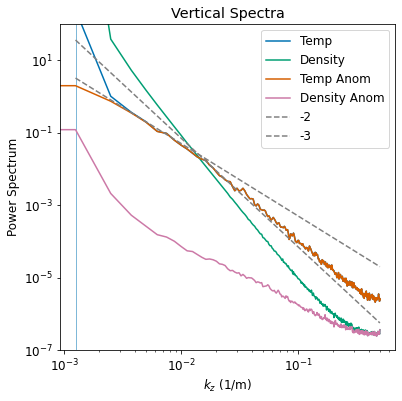

In [190]:
plt.figure(figsize=(6,6))

temp_spec_pres.sel(time=slice(120,130)).mean('time').plot(label='Temp')
dens_spec_pres.sel(time=slice(130,150)).mean('time').plot(label='Density')

temp_anom_spec_pres.sel(time=slice(120,130)).mean('time').plot(label='Temp Anom')
dens_anom_spec_pres.sel(time=slice(130,150)).mean('time').plot(label='Density Anom')


kz = temp_spec_pres.freq_pressure
plt.plot(kz, 0.5e-5*kz**(-2), '--', label='-2', color='gray')
plt.plot(kz, 7e-8*kz**(-3), '--', label='-3', color='gray')

plt.ylim([1e-7 , 100])
plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.vlines([1/(800)], 1e-9, 100, linewidths=0.5)


plt.xlabel('$k_z$ (1/m)')
plt.ylabel('Power Spectrum')
plt.title('Vertical Spectra')

In [191]:
temp_anom_spec_pres_time = xrft.power_spectrum(temp_anom.sel(pressure=slice(150, 950)).dropna(dim='time'),
                               dim=['pressure','time'], window=True)

dens_anom_spec_pres_time = xrft.power_spectrum(dens_anom.sel(pressure=slice(150, 950)).dropna(dim='time'),
                               dim=['pressure','time'], window=True)

In [200]:
temp_anom_spec_pres_time

<xarray.DataArray (freq_pressure: 801, freq_time: 3434)>
array([[2.68316211e-11, 1.09767072e-10, 1.99135485e-12, ...,
        1.31845918e-10, 5.60855932e-11, 5.76739618e-11],
       [1.24869896e-10, 4.02918035e-10, 7.40835621e-11, ...,
        5.27564776e-10, 2.41702290e-10, 8.17082150e-11],
       [5.06392211e-11, 1.51253204e-10, 1.70396403e-10, ...,
        1.03665166e-10, 2.38907500e-11, 1.95762039e-12],
       ...,
       [5.06392211e-11, 1.95762039e-12, 2.38907500e-11, ...,
        4.62132125e-11, 1.70396403e-10, 1.51253204e-10],
       [1.24869896e-10, 8.17082150e-11, 2.41702290e-10, ...,
        1.64743256e-11, 7.40835621e-11, 4.02918035e-10],
       [2.68316211e-11, 5.76739618e-11, 5.60855932e-11, ...,
        2.04669485e-10, 1.99135485e-12, 1.09767072e-10]])
Coordinates:
  * freq_pressure          (freq_pressure) float64 -0.4994 -0.4981 ... 0.4994
  * freq_time              (freq_time) float64 -20.0 -19.99 ... 19.98 19.99
    freq_pressure_spacing  float64 0.001248
    freq_time_spacing      float64 0.01165

(array([67016., 62358., 57418., 51836., 48054., 44338., 40370., 38062.,
        34682., 33016., 30152., 29116., 26444., 25020., 23542., 22454.,
        21160., 20218., 18624., 18082., 17264., 16694., 15666., 14750.,
        14570., 14054., 13246., 12774., 12348., 11660., 11174., 10762.,
        10488., 10054.,  9834.,  9726.,  9446.,  9136.,  8622.]),
 array([1.00000000e-12, 2.66153846e-11, 5.22307692e-11, 7.78461538e-11,
        1.03461538e-10, 1.29076923e-10, 1.54692308e-10, 1.80307692e-10,
        2.05923077e-10, 2.31538462e-10, 2.57153846e-10, 2.82769231e-10,
        3.08384615e-10, 3.34000000e-10, 3.59615385e-10, 3.85230769e-10,
        4.10846154e-10, 4.36461538e-10, 4.62076923e-10, 4.87692308e-10,
        5.13307692e-10, 5.38923077e-10, 5.64538462e-10, 5.90153846e-10,
        6.15769231e-10, 6.41384615e-10, 6.67000000e-10, 6.92615385e-10,
        7.18230769e-10, 7.43846154e-10, 7.69461538e-10, 7.95076923e-10,
        8.20692308e-10, 8.46307692e-10, 8.71923077e-10, 8.97538462e-10

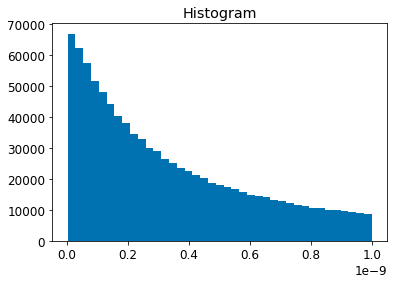

In [204]:
temp_anom_spec_pres_time.plot.hist(bins=np.linspace(1e-12,1e-9,40))

(0.001, 1)

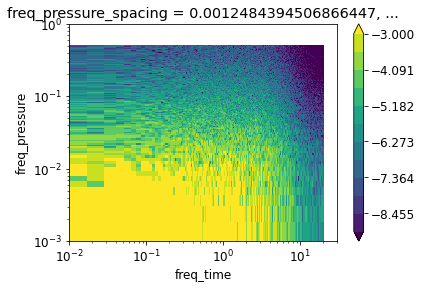

In [211]:
np.log10(temp_anom_spec_pres_time).plot(vmin=-9, vmax=-3, levels=12)
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-2, 30])
plt.ylim([1e-3, 1])

(0.001, 1)

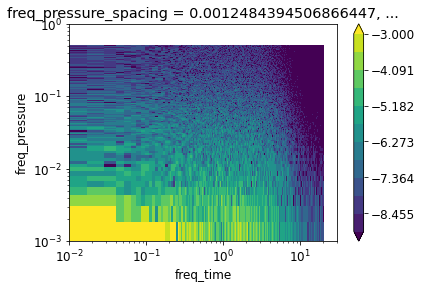

In [212]:
np.log10(dens_anom_spec_pres_time).plot(vmin=-9, vmax=-3, levels=12)
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-2, 30])
plt.ylim([1e-3, 1])

## Variograms 

Variograms help understand the spatio-temporal correlations present in the data. 

### 2D Variograms 

Look at 2D variograms at different depths, different regions and for different variables. 

In [340]:
def great_circle_distance(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance between one or multiple pairs of
    points given in spherical coordinates. Spherical coordinates are expected
    in degrees. Angle definition follows standard longitude/latitude definition.
    This uses the arctan version of the great-circle distance function
    (en.wikipedia.org/wiki/Great-circle_distance) for increased
    numerical stability.
    Parameters
    ----------
    lon1: float scalar or numpy array
        Longitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lat1: float scalar or numpy array
        Latitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lon2: float scalar or numpy array
        Longitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    lat2: float scalar or numpy array
        Latitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    Calculation of distances follows numpy elementwise semantics, so if
    an array of length N is passed, all input parameters need to be
    arrays of length N or scalars.
    Returns
    -------
    distance: float scalar or numpy array
        The great circle distance(s) (in degrees) between the
        given pair(s) of points.
    """
    # Convert to radians:
    lat1 = np.array(lat1) * np.pi / 180.0
    lat2 = np.array(lat2) * np.pi / 180.0
    dlon = (lon1 - lon2) * np.pi / 180.0

    # Evaluate trigonometric functions that need to be evaluated more
    # than once:
    c1 = np.cos(lat1)
    s1 = np.sin(lat1)
    c2 = np.cos(lat2)
    s2 = np.sin(lat2)
    cd = np.cos(dlon)

    # This uses the arctan version of the great-circle distance function
    # from en.wikipedia.org/wiki/Great-circle_distance for increased
    # numerical stability.
    # Formula can be obtained from [2] combining eqns. (14)-(16)
    # for spherical geometry (f=0).

    return (
        180.0
        / np.pi
        * np.arctan2(
            np.sqrt((c2 * np.sin(dlon)) ** 2 + (c1 * s2 - s1 * c2 * cd) ** 2),
            s1 * s2 + c1 * c2 * cd,
        )
    )

In [360]:
# Function to select data from a specific region.
def select_data(ds_glid, var, Z1, Z2, lon1, lon2, lat1, lat2): 
    
    lat = ds_glid.latitude.where( ( (ds_glid.pressure>Z1) & 
                                    (ds_glid.pressure<Z2) &
                                    (ds_glid.longitude<lon1) &
                                    (ds_glid.longitude>lon2) &
                                    (ds_glid.latitude<lat1) & 
                                    (ds_glid.latitude>lat2) ), 
                                 drop=True).groupby('dives').mean()
    
    lon = ds_glid.longitude.where( ( (ds_glid.pressure>Z1) & 
                                    (ds_glid.pressure<Z2) &
                                    (ds_glid.longitude<lon1) &
                                    (ds_glid.longitude>lon2) &
                                    (ds_glid.latitude<lat1) & 
                                    (ds_glid.latitude>lat2) ), 
                                 drop=True).groupby('dives').mean()
    
    time = ds_glid.time.where( ( (ds_glid.pressure>Z1) & 
                                    (ds_glid.pressure<Z2) &
                                    (ds_glid.longitude<lon1) &
                                    (ds_glid.longitude>lon2) &
                                    (ds_glid.latitude<lat1) & 
                                    (ds_glid.latitude>lat2) ), 
                                 drop=True).groupby('dives').mean()
    
    var_sel = ds_glid[var].where( ( (ds_glid.pressure>Z1) & 
                                    (ds_glid.pressure<Z2) &
                                    (ds_glid.longitude<lon1) &
                                    (ds_glid.longitude>lon2) &
                                    (ds_glid.latitude<lat1) & 
                                    (ds_glid.latitude>lat2) ), 
                                 drop=True).groupby('dives').mean()
    
    return [time, lat, lon, var_sel]


def variogram_2D(glider_dict, var, 
                 Z1, Z2, lon1, lon2, lat1, lat2):
    """
    # Function to estimate the variogram from the data 
    # inputs: variable, region X, region z to avg over
    # assume temporally stationary,
    # ouputs: 2D variogram, nsamples per bin

    Inputs: 
        - glider_dict: Dictionary containing all the different glider
        datasets, we will cycle through this.
        - var: variable for which the variogram will be produced. 
        - Z1, ... lat2: regions over which we will do the estimation.
    """
    
    time = np.array([], dtype='datetime64[ns]')
    lat = np.array([])
    lon = np.array([])
    var_sel = np.array([])
    
    for key in glider_dict.keys():
        
        [time_ind, lat_ind, lon_ind, var_sel_ind] = select_data(glider_dict[key], var,
                                               Z1, Z2, lon1, lon2, lat1, lat2)
        
        time = np.concatenate([time, time_ind])
        lat = np.concatenate([lat, lat_ind])
        lon = np.concatenate([lon, lon_ind])
        var_sel = np.concatenate([var_sel, var_sel_ind])
        
    
    x1, x2 = np.meshgrid(lon, lon, sparse=True)
    y1, y2 = np.meshgrid(lat, lat, sparse=True)
    t1, t2 = np.meshgrid(time, time, sparse=True)
    var1, var2 = np.meshgrid(var_sel, var_sel, sparse=True)
    
    
    dX = great_circle_distance(x1, y1, x2, y2)
    dt = np.abs(t1 - t2)
    dVar2 = (var1 - var2)**2
        
        
    # remove repetitions on the other side of the matrices
    indices = np.indices(dX.shape)
    dX = dX[(indices[0,:,:] > indices[1,:,:])]*110 # convert to km
    dt = (dt[(indices[0,:,:] > indices[1,:,:])]).astype('float')/1e9/3600 # convert to hours
    dVar2 = dVar2[(indices[0,:,:] > indices[1,:,:])]
    
    # can be automated late
    Xbins = np.logspace(-2, 3, 51) # 10m to 1000km
    Tbins = np.logspace(-3, 4, 41) # 
    
    variogram_var_2D = np.nan*np.ones((len(Xbins)-1,len(Tbins)-1))
    nsamples_2D = np.nan*np.ones((len(Xbins)-1,len(Tbins)-1))
    
    for i in range(len(Xbins)-1):
        for j in range(len(Tbins)-1):
            
            nsamples_2D[i,j] = dX[(dX>=Xbins[i]) & (dX<Xbins[i+1]) &  
                                      (dt>=Tbins[j]) & (dt<Tbins[j+1])].size
            
            variogram_var_2D[i,j] = np.nanmean(dVar2[(dX>=Xbins[i]) & (dX<Xbins[i+1])
                                                 &  (dt>=Tbins[j]) 
                                                & (dt<Tbins[j+1])])
    
    Xaxis = 0.5*(Xbins[0:-1] + Xbins[1:])
    Taxis = 0.5*(Tbins[0:-1] + Tbins[1:])
    
    return [Xaxis, Taxis, nsamples_2D, variogram_var_2D]


In [361]:
glider_dict = {'659': ds_659, '660': ds_660}

In [362]:
lon1 = 40; 
lon2 = 28; 

In [363]:
# temp 

[Xaxis, Taxis, nsamples_2D_temp_N_shallow, variogram_2D_temp_N_shallow] = variogram_2D(glider_dict, 'temperature', 
                                                 20, 70, lon1, lon2, -50, -51.5)
[Xaxis, Taxis, nsamples_2D_temp_N_deep, variogram_2D_temp_N_deep] = variogram_2D(glider_dict, 'temperature', 
                                                 500, 550, lon1, lon2, -50, -51.5)

[Xaxis, Taxis, nsamples_2D_temp_S_shallow, variogram_2D_temp_S_shallow] = variogram_2D(glider_dict, 'temperature', 
                                                 20, 70, lon1, lon2, -51.5, -55)
[Xaxis, Taxis, nsamples_2D_temp_S_deep, variogram_2D_temp_S_deep] = variogram_2D(glider_dict, 'temperature', 
                                                 500, 550, lon1, lon2, -51.5, -55)

# Density
[Xaxis, Taxis, nsamples_2D_dens_N_shallow, variogram_2D_dens_N_shallow] = variogram_2D(glider_dict, 'density', 
                                                 20, 70, lon1, lon2, -50, -51.5)
[Xaxis, Taxis, nsamples_2D_dens_N_deep, variogram_2D_dens_N_deep] = variogram_2D(glider_dict, 'density', 
                                                 500, 550, lon1, lon2, -50, -51.5)

[Xaxis, Taxis, nsamples_2D_dens_S_shallow, variogram_2D_dens_S_shallow] = variogram_2D(glider_dict, 'density', 
                                                 20, 70, lon1, lon2, -51.5, -55)
[Xaxis, Taxis, nsamples_2D_dens_S_deep, variogram_2D_dens_S_deep] = variogram_2D(glider_dict, 'density', 
                                                 500, 550, lon1, lon2, -51.5, -55)

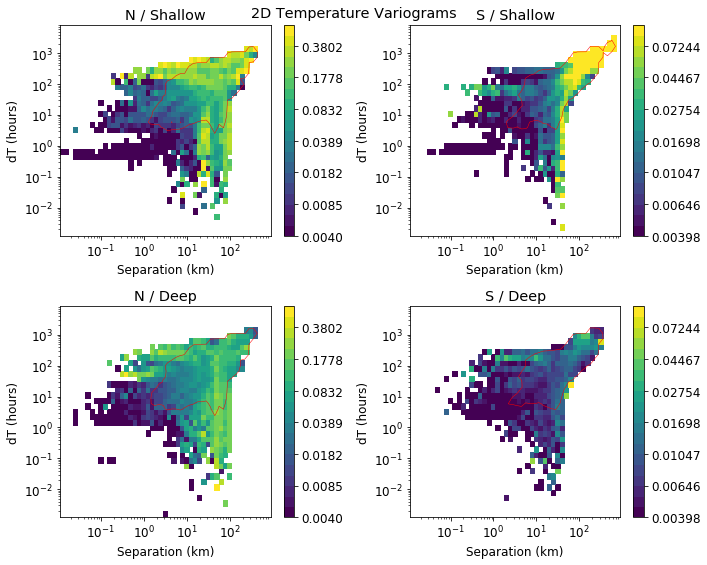

In [366]:
# temp plots 
plt.figure(figsize=(10,8))

levels_T_N = np.logspace(-2.4,-0.2,21)
levels_T_S = np.logspace(-2.4,-1,21)
cmap = plt.get_cmap('viridis')
norm_N = BoundaryNorm(levels_T_N, ncolors=cmap.N, clip=True)
norm_S = BoundaryNorm(levels_T_S, ncolors=cmap.N, clip=True)

plt.subplot(221)



plt.pcolormesh(Xaxis, Taxis, (variogram_2D_temp_N_shallow).T, 
               cmap=cmap, norm=norm_N)

plt.colorbar()
plt.contour(Xaxis, Taxis, nsamples_2D_temp_N_shallow.T, levels=[100], colors='r',
           linewidths=0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Separation (km)')
plt.ylabel('dT (hours)')
plt.title('N / Shallow')

plt.subplot(222)

plt.pcolormesh(Xaxis, Taxis, (variogram_2D_temp_S_shallow).T,
              cmap=cmap, norm=norm_S)

plt.colorbar()
plt.contour(Xaxis, Taxis, nsamples_2D_temp_S_shallow.T, levels=[100], colors='r',
           linewidths=0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Separation (km)')
plt.ylabel('dT (hours)')
plt.title('S / Shallow')


plt.subplot(223)

plt.pcolormesh(Xaxis, Taxis, (variogram_2D_temp_N_deep).T, 
               cmap=cmap, norm=norm_N)

plt.colorbar()
plt.contour(Xaxis, Taxis, nsamples_2D_temp_N_deep.T, levels=[100], colors='r',
           linewidths=0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Separation (km)')
plt.ylabel('dT (hours)')
plt.title('N / Deep')

plt.subplot(224)

plt.pcolormesh(Xaxis, Taxis, (variogram_2D_temp_S_deep).T,
              cmap=cmap, norm=norm_S)

plt.colorbar()
plt.contour(Xaxis, Taxis, nsamples_2D_temp_S_deep.T, levels=[100], colors='r',
           linewidths=0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Separation (km)')
plt.ylabel('dT (hours)')
plt.title('S / Deep')


plt.suptitle('2D Temperature Variograms')
plt.tight_layout()

plt.savefig('temp_2d_variogram.pdf')

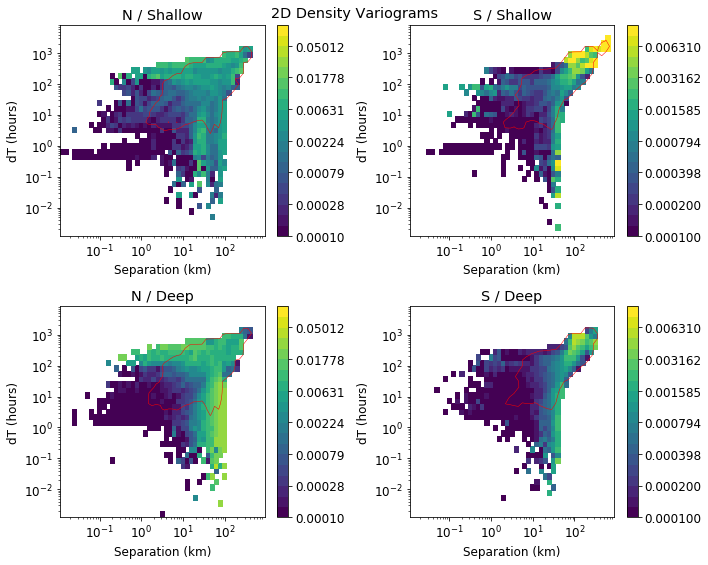

In [367]:
# density plots
# temp plots 
plt.figure(figsize=(10,8))

levels_dens_N = np.logspace(-4,-1,21)
levels_dens_S = np.logspace(-4,-2,21)

cmap = plt.get_cmap('viridis')
norm_N = BoundaryNorm(levels_dens_N, ncolors=cmap.N, clip=True)
norm_S = BoundaryNorm(levels_dens_S, ncolors=cmap.N, clip=True)

plt.subplot(221)

plt.pcolormesh(Xaxis, Taxis, (variogram_2D_dens_N_shallow).T, 
               cmap=cmap, norm=norm_N)

plt.colorbar()
plt.contour(Xaxis, Taxis, nsamples_2D_dens_N_shallow.T, levels=[100], colors='r',
           linewidths=0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Separation (km)')
plt.ylabel('dT (hours)')
plt.title('N / Shallow')

plt.subplot(222)

plt.pcolormesh(Xaxis, Taxis, (variogram_2D_dens_S_shallow).T,
              cmap=cmap, norm=norm_S)

plt.colorbar()
plt.contour(Xaxis, Taxis, nsamples_2D_dens_S_shallow.T, levels=[100], colors='r',
           linewidths=0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Separation (km)')
plt.ylabel('dT (hours)')
plt.title('S / Shallow')


plt.subplot(223)

plt.pcolormesh(Xaxis, Taxis, (variogram_2D_dens_N_deep).T, 
               cmap=cmap, norm=norm_N)

plt.colorbar()
plt.contour(Xaxis, Taxis, nsamples_2D_dens_N_deep.T, levels=[100], colors='r',
           linewidths=0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Separation (km)')
plt.ylabel('dT (hours)')
plt.title('N / Deep')

plt.subplot(224)

plt.pcolormesh(Xaxis, Taxis, (variogram_2D_dens_S_deep).T,
              cmap=cmap, norm=norm_S)

plt.colorbar()
plt.contour(Xaxis, Taxis, nsamples_2D_dens_S_deep.T, levels=[100], colors='r',
           linewidths=0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Separation (km)')
plt.ylabel('dT (hours)')
plt.title('S / Deep')


plt.suptitle('2D Density Variograms')
plt.tight_layout()

plt.savefig('dens_2d_variogram.pdf')

### 1D Variograms 

Look at 1D variograms at different depths, different regions and for different variables. 

In [368]:
def variogram_1D_space(glider_dict, var, tscale1, tscale2,
                 Z1, Z2, lon1, lon2, lat1, lat2):
    """
    # Function to estimate the variogram from the data 
    # inputs: variable, region X, region z to avg over
    # assume temporally stationary,
    # ouputs: 1D variogram, nsamples per bin

    Inputs: 
        - glider_dict: Dictionary containing all the different glider
        datasets, we will cycle through this.
        - var: variable for which the variogram will be produced. 
        - tscale1, tscale2: what timescales to average over
        - Z1, ... lat2: regions over which we will do the estimation.
    """
    
    time = np.array([], dtype='datetime64[ns]')
    lat = np.array([])
    lon = np.array([])
    var_sel = np.array([])
    
    for key in glider_dict.keys():
        
        [time_ind, lat_ind, lon_ind, var_sel_ind] = select_data(glider_dict[key], var,
                                               Z1, Z2, lon1, lon2, lat1, lat2)
        
        time = np.concatenate([time, time_ind])
        lat = np.concatenate([lat, lat_ind])
        lon = np.concatenate([lon, lon_ind])
        var_sel = np.concatenate([var_sel, var_sel_ind])
        
    
    x1, x2 = np.meshgrid(lon, lon, sparse=True)
    y1, y2 = np.meshgrid(lat, lat, sparse=True)
    t1, t2 = np.meshgrid(time, time, sparse=True)
    var1, var2 = np.meshgrid(var_sel, var_sel, sparse=True)
    
    
    dX = great_circle_distance(x1, y1, x2, y2)
    dt = np.abs(t1 - t2)
    dVar2 = (var1 - var2)**2
        
        
    # remove repetitions on the other side of the matrices
    indices = np.indices(dX.shape)
    dX = dX[(indices[0,:,:] > indices[1,:,:])]*110 # convert to km
    dt = (dt[(indices[0,:,:] > indices[1,:,:])]).astype('float')/1e9/3600 # convert to hours
    dVar2 = dVar2[(indices[0,:,:] > indices[1,:,:])]
    
    # can be automated late
    Xbins = np.logspace(-2, 3, 51) # 10m to 1000km
    
    
    variogram_var_1D = np.nan*np.ones((len(Xbins)-1,1))
    nsamples_1D = np.nan*np.ones((len(Xbins)-1,1))
    
    for i in range(len(Xbins)-1):
            
            nsamples_1D[i] = dX[(dX>=Xbins[i]) & (dX<Xbins[i+1]) &  (dt>=tscale1) & (dt<tscale2)].size
            
            variogram_var_1D[i] = np.nanmean(dVar2[(dX>=Xbins[i]) & (dX<Xbins[i+1]) &  (dt>=tscale1) & (dt<tscale2)])
    
    Xaxis = 0.5*(Xbins[0:-1] + Xbins[1:])
    
    return [Xaxis, nsamples_1D, variogram_var_1D]


In [369]:
# temp 

[Xaxis, nsamples_1D_temp_N_shallow, variogram_1D_temp_N_shallow] = variogram_1D_space(glider_dict, 'temperature', 
                                                 0,25, 20, 70, lon1, lon2, -50, -51.5)
[Xaxis, nsamples_1D_temp_N_deep, variogram_1D_temp_N_deep] = variogram_1D_space(glider_dict, 'temperature', 
                                                 0,25, 500, 550, lon1, lon2, -50, -51.5)

[Xaxis, nsamples_1D_temp_S_shallow, variogram_1D_temp_S_shallow] = variogram_1D_space(glider_dict, 'temperature', 
                                                 0,25, 20, 70, lon1, lon2, -51.5, -55)
[Xaxis, nsamples_1D_temp_S_deep, variogram_1D_temp_S_deep] = variogram_1D_space(glider_dict, 'temperature', 
                                                 0,25, 500, 550, lon1, lon2, -51.5, -55)
 


In [370]:
# density

[Xaxis, nsamples_1D_dens_N_shallow, variogram_1D_dens_N_shallow] = variogram_1D_space(glider_dict, 'density', 
                                                 0,25, 20, 70, lon1, lon2, -50, -51.5)
[Xaxis, nsamples_1D_dens_N_deep, variogram_1D_dens_N_deep] = variogram_1D_space(glider_dict, 'density', 
                                                 0,25, 500, 550, lon1, lon2, -50, -51.5)

[Xaxis, nsamples_1D_dens_S_shallow, variogram_1D_dens_S_shallow] = variogram_1D_space(glider_dict, 'density', 
                                                 0,25, 20, 70, lon1, lon2, -51.5, -55)
[Xaxis, nsamples_1D_dens_S_deep, variogram_1D_dens_S_deep] = variogram_1D_space(glider_dict, 'density', 
                                                 0,25, 500, 550, lon1, lon2, -51.5, -55)
 


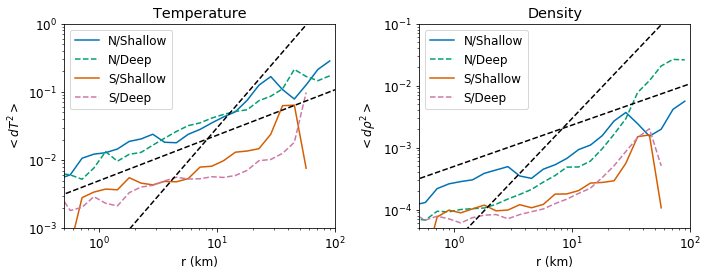

In [391]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(Xaxis, variogram_1D_temp_N_shallow, label='N/Shallow')
plt.plot(Xaxis, variogram_1D_temp_N_deep, '--', label='N/Deep')

plt.plot(Xaxis, variogram_1D_temp_S_shallow, label='S/Shallow')
plt.plot(Xaxis, variogram_1D_temp_S_deep, '--', label='S/Deep')

plt.plot(Xaxis, 5e-3*Xaxis**(2/3),'--', color='k')
plt.plot(Xaxis, 3e-4*Xaxis**(2),'--', color='k')
plt.legend()
plt.xlim([0.5, 100])
plt.ylim([0.001, 1])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r (km)')
plt.ylabel(r'$<d T^2>$')
plt.title('Temperature')


plt.subplot(122)
plt.plot(Xaxis, variogram_1D_dens_N_shallow, label='N/Shallow')
plt.plot(Xaxis, variogram_1D_dens_N_deep, '--', label='N/Deep')

plt.plot(Xaxis, variogram_1D_dens_S_shallow, label='S/Shallow')
plt.plot(Xaxis, variogram_1D_dens_S_deep, '--', label='S/Deep')

plt.plot(Xaxis, 5e-4*Xaxis**(2/3), '--', color='k')
plt.plot(Xaxis, 3e-5*Xaxis**(2),'--', color='k')
plt.legend()
plt.xlim([0.5, 100])
plt.ylim([0.00005, 0.1])
plt.xscale('log')
plt.yscale('log')
plt.title('Density')
plt.xlabel('r (km)')
plt.ylabel(r'$<d \rho^2>$')
plt.tight_layout()

plt.savefig('variogram_1d.pdf')

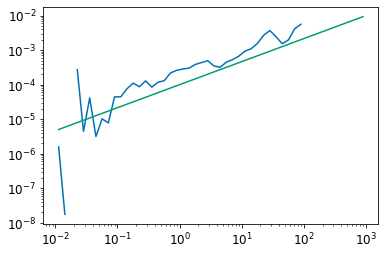

In [374]:
plt.plot(Xaxis, variogram_1D_dens_N_shallow, label='N/Shallow')

plt.plot(Xaxis, 1e-4*Xaxis**(2/3))

plt.xscale('log')
plt.yscale('log')

### Frequency spectra 


In [56]:
# estimate isopycnal displacement 

rho = ds_659.density.where(ds_659.dives==300., drop=True)
temp = ds_659.temperature.where(ds_659.dives==300., drop=True)
z = ds_659.pressure.where(ds_659.dives==300., drop=True)

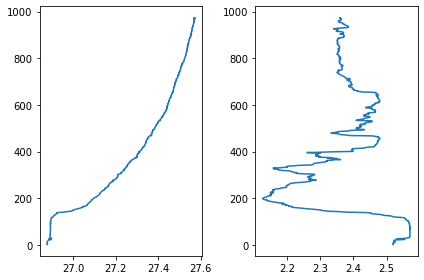

In [57]:

plt.subplot(121)
plt.plot(rho, z)

plt.subplot(122)
plt.plot(temp, z)

plt.tight_layout()

In [70]:
vert_bins = np.arange(0,900, 10)

In [61]:
density_regridded= gt.grid_data(ds_659.dives, ds_659.pressure, 
                                ds_659.density, bins = vert_bins)

Mean bin size = 10.00
Mean depth binned (50 m) vertical sampling frequency = 0.63


In [71]:
time_regridded= gt.grid_data(ds_659.dives, ds_659.pressure, 
                                ds_659.time.astype('float'), bins = vert_bins)

Mean bin size = 10.00
Mean depth binned (50 m) vertical sampling frequency = 0.63


In [336]:
lat_regridded= gt.grid_data(ds_659.dives, ds_659.pressure, 
                                ds_659.latitude.astype('float'), bins = vert_bins)

Mean bin size = 10.00
Mean depth binned (50 m) vertical sampling frequency = 0.63


In [337]:
lon_regridded= gt.grid_data(ds_659.dives, ds_659.pressure, 
                                ds_659.longitude.astype('float'), bins = vert_bins)

Mean bin size = 10.00
Mean depth binned (50 m) vertical sampling frequency = 0.63


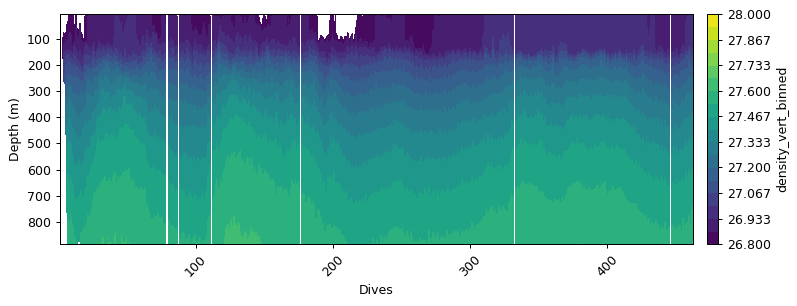

In [68]:
gt.plot.contourf(density_regridded, levels=np.linspace(26.8,28,19))

In [38]:
z27_3 = np.interp(27.3, rho, z)

In [339]:
ndives = np.unique(ds_659.dives)

iso = [27.1,27.3, 27.4, 27.45]

Z_iso  = np.nan * np.ones([len(ndives), len(iso)])
time_iso = np.nan * np.ones([len(ndives), len(iso)])
lat_iso = np.nan * np.ones([len(ndives), len(iso)])
lon_iso = np.nan * np.ones([len(ndives), len(iso)])

z = density_regridded.pressure


for i in range(len(ndives)):
    rho = density_regridded.where(density_regridded.dives==ndives[i], drop=True)
    
    time = time_regridded.where(density_regridded.dives==ndives[i], drop=True).astype('float')
    
    lat  = lat_regridded.where(density_regridded.dives==ndives[i], drop=True)
    lon  = lon_regridded.where(density_regridded.dives==ndives[i], drop=True)
    

    for j in range(len(iso)):
        Z_iso[i,j] = np.interp(iso[j], rho[:,0], z)
        
        time_iso[i,j] = np.interp(iso[j], rho[:,0], time[:,0])
        
        lat_iso[i,j] = np.interp(iso[j], rho[:,0], lat[:,0])
        lon_iso[i,j] = np.interp(iso[j], rho[:,0], lon[:,0])

In [341]:
Z_xr = xr.Dataset({'Z_iso':(['dives','isopycnal'], Z_iso), 
                   'time_iso':(['dives','isopycnal'], time_iso),
                   'lat_iso':(['dives','isopycnal'], lat_iso),
                   'lon_iso':(['dives','isopycnal'], lon_iso)}, 
                    coords={'dives': ndives, 'isopycnal': iso})

(700, 100)

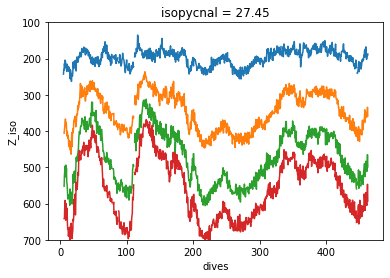

In [264]:
for i in range(4):
    Z_xr.Z_iso.isel(isopycnal=i).plot()
    
plt.ylim([700, 100])    

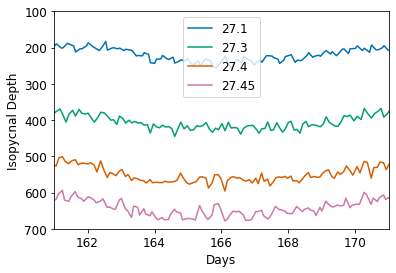

In [319]:
#plt.figure(figsize=(1,3))
for i in range(4):
    plt.plot((Z_xr.time_iso.isel(isopycnal=i)-Z_xr.time_iso.isel(isopycnal=i)[10])/1e9/3600/24 + 120,
             Z_xr.Z_iso.isel(isopycnal=i), label=iso[i])
    
plt.ylim([700, 100])    
plt.xlim([161, 171])
plt.xlabel('Days')
plt.ylabel('Isopycnal Depth')
plt.legend()
plt.savefig('isopycnal_displacement.png')

In [345]:
lat_iso.shape

(923, 4)

In [353]:
dX_along.shape

(922,)

In [354]:
dX_along = np.zeros([922,4 ])
for i in range(len(iso)):
    dX_along[:,i] = great_circle_distance(lon_iso[0:-1,i], lat_iso[0:-1,i], 
                                 lon_iso[1:,i], lat_iso[1:,i])

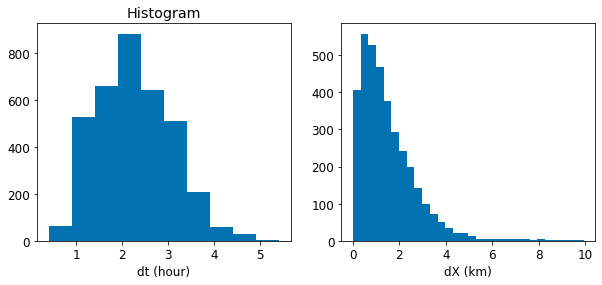

In [358]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
(Z_xr.time_iso/1e9/3600).diff('dives').plot.hist();
plt.xlabel('dt (hour)')

plt.subplot(122)
plt.hist(np.reshape(dX_along,-1)*110, bins=30);
plt.xlabel('dX (km)')

plt.savefig('one_glider_samples.png')

In [147]:
start_time = (Z_xr.time_iso/1e9/3600).min()
end_time = (Z_xr.time_iso/1e9/3600).max()
diff_time =(Z_xr.time_iso/1e9/3600).diff('dives').min('dives')
print(start_time, end_time, diff_time)

<xarray.DataArray 'time_iso' ()>
array(432402.24235189) <xarray.DataArray 'time_iso' ()>
array(434473.43568519) <xarray.DataArray 'time_iso' (isopycnal: 4)>
array([0.67904573, 0.94377247, 0.90008475, 0.39865738])
Coordinates:
  * isopycnal  (isopycnal) float64 27.1 27.3 27.4 27.45


In [249]:
tax = np.arange(start_time, end_time, 0.25)*1e9*3600
tax.shape

(8285,)

In [250]:
(tax[-1] - tax[0])/24/1e9/3600

86.29166666666667

In [251]:
Z_iso_interp = np.zeros([len(iso), len(tax)])
for i in range(len(iso)):
    time_temp = Z_xr.time_iso.isel(isopycnal=i)
    Z_iso_interp[i,:] = np.interp(tax, 
                        time_temp.where(np.logical_not(np.isnan(time_temp)), drop=True ), 
                         Z_xr.Z_iso.where(np.logical_not(np.isnan(time_temp)),
                                        drop=True ).isel(isopycnal=i) )


Z_iso_interp = xr.DataArray(Z_iso_interp, dims =['iso','time'],
                            coords={'iso':iso, 'time':tax/1e9/3600})

In [331]:
Z_iso_interp = Z_iso_interp.rename('isopycnal_displacement')

In [332]:
Z_iso_interp

<xarray.DataArray 'isopycnal_displacement' (iso: 4, time: 8285)>
array([[242.80928454, 238.74992361, 234.69056267, ..., 188.2087666 ,
        187.87972263, 187.55067866],
       [406.05189402, 406.05189402, 406.05189402, ..., 356.80589274,
        358.43198197, 358.43198197],
       [552.32538226, 552.32538226, 552.32538226, ..., 498.70839226,
        498.70839226, 498.70839226],
       [641.94568083, 641.94568083, 641.94568083, ..., 593.12023173,
        593.12023173, 593.12023173]])
Coordinates:
  * iso      (iso) float64 27.1 27.3 27.4 27.45
  * time     (time) float64 4.324e+05 4.324e+05 ... 4.345e+05 4.345e+05

In [335]:
Z_iso_interp.to_netcdf('/Users/dhruvbalwada/work_root/sogos/data/processed/isopycnal_displacement.nc')

In [228]:
import xrft

In [235]:
Z_iso_interp.chunk({'time':len(tax)/5})

<xarray.DataArray (iso: 4, time: 8285)>
dask.array<xarray-<this-array>, shape=(4, 8285), dtype=float64, chunksize=(4, 1657), chunktype=numpy.ndarray>
Coordinates:
  * iso      (iso) float64 27.1 27.3 27.4 27.45
  * time     (time) float64 4.324e+05 4.324e+05 ... 4.345e+05 4.345e+05

In [236]:
Z_iso_ps = xrft.power_spectrum(Z_iso_interp.chunk({'time':len(tax)/5}),
                                                 dim=['time'],
                                                 chunks_to_segments=True)

In [237]:
Z_iso_ps = Z_iso_ps.mean('time_segment')

In [247]:
1/0.25

4.0

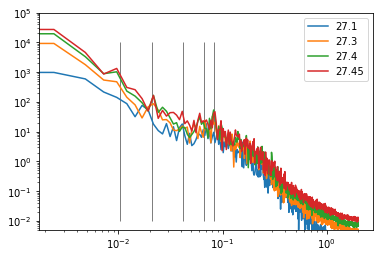

In [267]:
for i in range(len(iso)):
    plt.plot(Z_iso_ps.freq_time, Z_iso_ps.isel(iso=i), label=iso[i])
    
plt.vlines([1/12, 1/15, 1/24, 1/48, 1/96], 0.01, 1e4, linewidths=0.5)

plt.xscale('log')
plt.yscale('log')
plt.ylim([0.005, 1e5])
plt.legend()

In [109]:
import xrft 

In [110]:
Z_iso

array([[         nan,          nan,          nan,          nan],
       [         nan,          nan,          nan,          nan],
       [         nan,          nan,          nan,          nan],
       ...,
       [189.21446707, 353.98466866, 493.26348241, 580.40885172],
       [192.50729912, 334.38387262, 465.00213297, 546.91763233],
       [187.29621804, 358.43198197, 498.70839226, 593.12023173]])

In [ ]:
rho = ds_659.density.where(np.logical_and(ds_659.pressure>500, 
                                    ds_659.pressure<530), drop='True').groupby('dives').mean()
T = ds_659.time.where(np.logical_and(ds_659.pressure>500, 
                                    ds_659.pressure<530), drop='True').groupby('dives').mean()



In [ ]:
rho = ds_659.density.where(( (ds_659.pressure>500) &
                                    (ds_659.pressure<530)), 
                           drop='True').groupby('dives').mean()

In [ ]:
dT = (T[1:].values - T[0:-1].values)

In [ ]:
plt.hist(dT.astype('float')/1e9/3600);

In [ ]:
plt.plot(T, rho, '.-')
plt.xlim([np.datetime64('2019-05-21'), np.datetime64('2019-05-25')])
plt.tight_layout()